# Research Skills: Spatiotemporal Data Analysis 
# Lecture 3 - More Forecasting 

Sharon Ong, Department of Cognitive Science and Artificial Intelligence – Tilburg University
Academic Year

# 1 Setting your data to use sklearn classifiers 

Forecasting is not the same as supervised regression. Even though you can used regression algorithms to solve forecasting problems, it is indirect. You need to do this carefully. There are a number of pitfalls such as, over-optimistic performance evaluation, information leakage, or “predicting the past” type errors.


In [9]:
!pip install sktime 
!pip install pmdarima
!pip install seaborn

# 1.1 Splitting the dataset 
Let's compare the data splitting to training and test with the `train_test_split` from `sklearn` and `temporal_train_test_split` from `sktime` . In supervised regression the ordering of rows does not matter, and train/test split is usually performed uniformly. In forecasting, the ordering does matter, both in training and in evaluation.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sktime.split import temporal_train_test_split
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series


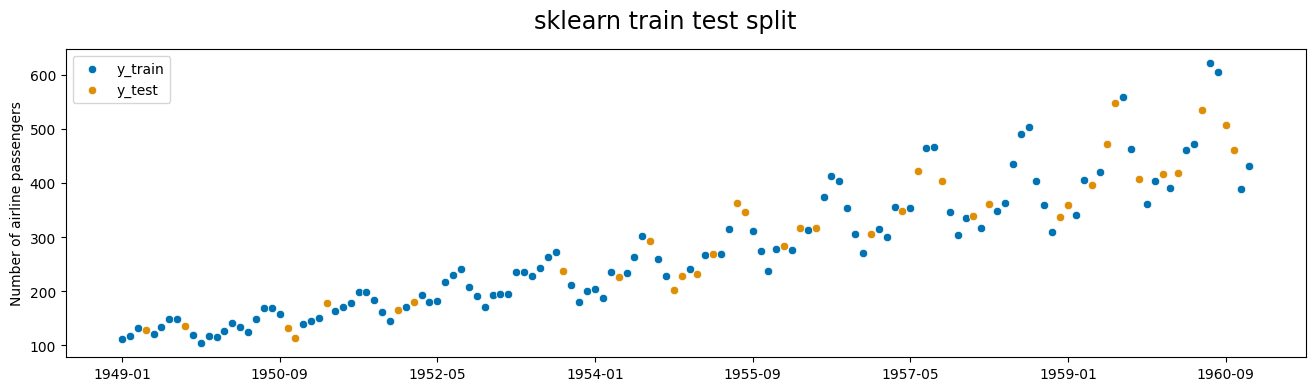

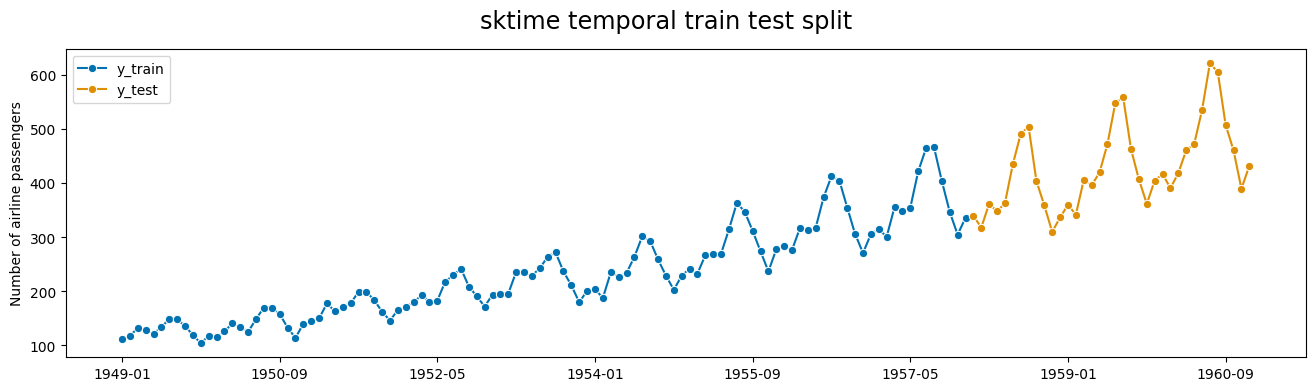

In [11]:
#comparision of data splitting with sklearn and sktime 
y = load_airline()


# for train_test_split: The data you are using to train a machine learning algorithm happens to have the information you are trying to predict.
y_train, y_test = train_test_split(y)
plot_series(y_train.sort_index(), y_test.sort_index(), labels=["y_train", "y_test"], title = "sklearn train test split");

y_train1, y_test1 = temporal_train_test_split(y)
plot_series(y_train1, y_test1, labels=["y_train", "y_test"], title = "sktime temporal train test split");



In [12]:
from sktime.forecasting.naive import NaiveForecaster

#forecasting 
tst_size = 36
# Specifying forecasting horizon
fh = np.arange(1, tst_size+1)

# Specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last")

# Fitting the forecaster
forecaster.fit(y_train1.v)

# step 5: querying predictions
y_temp = forecaster.predict(fh=fh)



plot_series(y_train1,y_temp, y_test1, labels=["y_train", "y_pred", "y_test"])



AttributeError: 'Series' object has no attribute 'v'

It is common practice to apply supervised regressors after transforming the data for forecasting, through lagging - for example, in auto-regressive reduction strategies. THe following code transform the data for regression 

In [ ]:
#code from sktime 

def split_into_train_test(data, in_num, fh):
    """
    Splits the series into train and test sets.

    Each step takes multiple points as inputs
    :param data: an individual TS
    :param fh: number of out of sample points
    :param in_num: number of input points for the forecast
    :return:
    """
    train, test = data[:-fh], data[-(fh + in_num) :]
    x_train, y_train = train[:-1], np.roll(train, -in_num)[:-in_num]
    x_test, y_test = test[:-1], np.roll(test, -in_num)[:-in_num]

    # reshape input to be [samples, time steps, features]
    # (N-NF samples, 1 time step, 1 feature)
    x_train = np.reshape(x_train, (-1, 1))
    x_test = np.reshape(x_test, (-1, 1))
    temp_test = np.roll(x_test, -1)
    temp_train = np.roll(x_train, -1)
    for _ in range(1, in_num):
        x_train = np.concatenate((x_train[:-1], temp_train[:-1]), 1)
        x_test = np.concatenate((x_test[:-1], temp_test[:-1]), 1)
        temp_test = np.roll(temp_test, -1)[:-1]
        temp_train = np.roll(temp_train, -1)[:-1]

    return x_train, y_train, x_test, y_test

In [ ]:
# now we can split the actual values of the time series
# suppose we want to predict 3 years ahead
fh = np.arange(1, 37)

x_train, y_train, x_test, y_test = split_into_train_test(y.values, 10, len(fh))
print(x_train.shape, y_train.shape)


(98, 10) (98,)


The `make_reduction` algorithm converts the regression output back to forecasts.  If we do not, we would invites errors in forecasts and evaluation especially, if one does not cleanly keep track of which data is known at what time. 

{'estimator': KNeighborsRegressor(n_neighbors=3),
 'pooling': 'local',
 'transformers': None,
 'window_length': 15,
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 3,
 'estimator__p': 2,
 'estimator__weights': 'uniform'}

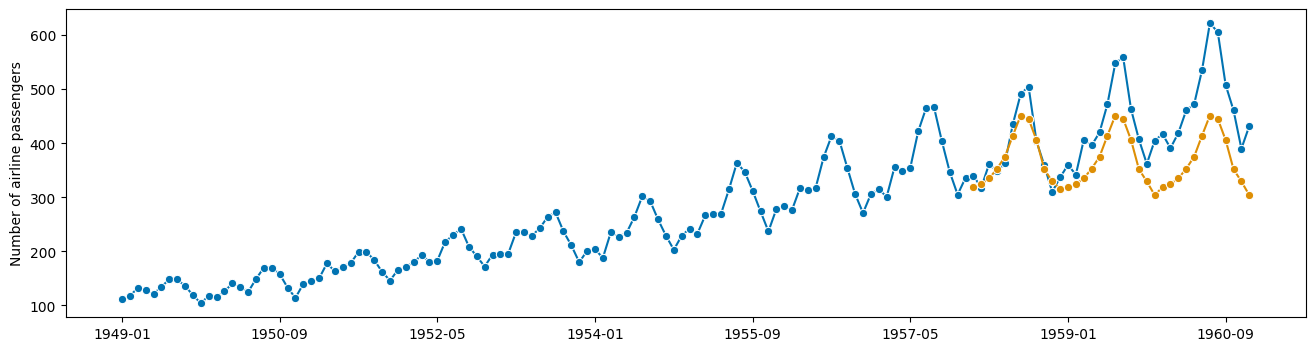

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
import pandas as pd
# suppose we want to predict 3 years ahead
fh = np.arange(1, 37)

regressor = KNeighborsRegressor(n_neighbors=3)
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

y_pred_rec = pd.Series(np.squeeze(y_pred), index=y_test1.index)

plot_series(y,y_pred_rec)

forecaster.get_params()


# 2 Comparing ETS and ARIMA 

Let's compare ETS and ARIMA 

In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import ARIMA
y = load_airline()
tst_size = 37
y_train, y_test = temporal_train_test_split(y, test_size=tst_size)


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

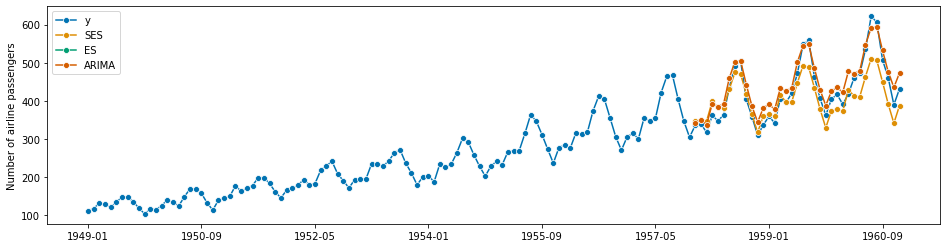

In [ ]:
fh = np.arange(1, tst_size+1)

forecasterTheta = ThetaForecaster(sp=12)  
forecasterTheta.fit(y_train)  
y_predTheta = forecasterTheta.predict(fh=fh)  

forecasterES = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=12) 
forecasterES.fit(y_train)  
y_predES = forecasterES.predict(fh=fh)  

forecasterA = ARIMA(order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), suppress_warnings=True)
forecasterA.fit(y_train)  
y_predA = forecasterA.predict(fh=fh)  

plot_series(y,y_predTheta,y_predES,y_predA, labels = ["y","SES","ES","ARIMA"])

